In [4]:
import pandas as pd

In [5]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
import shap

In [7]:
from sklearn.tree import export_graphviz
import graphviz

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [10]:
data = pd.read_csv('C:/Users/robyr/OneDrive/Desktop/FDS/new/clean_sub.csv')


Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


In [38]:
print(data_cleaned.columns)

Index(['id', 'country', 'operator', 'service', 'source', 'status', 'cycle',
       'adnet', 'revenue', 'subs_date', 'renewal_date', 'freemium_end_date',
       'unsubs_from', 'unsubs_date', 'service_price', 'currency',
       'profile_status', 'publisher', 'attempt_charging', 'success_billing',
       'combined_created_date', 'is_successful', 'revenue_usd',
       'service_price_usd'],
      dtype='object')


In [12]:
data = data[data['status'] !=2]


In [13]:
data_cleaned = data.drop(columns=['Unnamed: 0'])

missing_values = data_cleaned.isnull().sum()

data_types = data_cleaned.dtypes
unique_values = data_cleaned.nunique()

missing_values, data_types, unique_values

(id                       0
 country                  0
 operator                 0
 service                  0
 source                   0
 status                   0
 cycle                    0
 adnet                    0
 revenue                  0
 subs_date                0
 renewal_date             0
 freemium_end_date        0
 unsubs_from              0
 unsubs_date              0
 service_price            0
 currency                 0
 profile_status           0
 publisher                0
 attempt_charging         0
 success_billing          0
 combined_created_date    0
 is_successful            0
 revenue_usd              0
 service_price_usd        0
 dtype: int64,
 id                         int64
 country                   object
 operator                  object
 service                   object
 source                    object
 status                     int64
 cycle                     object
 adnet                     object
 revenue                    int64
 subs_d

In [14]:
data_cleaned['publisher'] = data_cleaned['publisher'].replace('STAR', 'star')
data_cleaned['publisher'] = data_cleaned['publisher'].str.replace(r'^lig-.*', 'lig', regex=True)
data_cleaned['publisher'] = data_cleaned['publisher'].str.replace(r'^star-.*', 'star', regex=True)


In [15]:
print(data_cleaned['publisher'].unique())

['Unkown' 'star' 'lig' 'MOV' 'lumos']


In [16]:
# List of columns that appear to be dates
date_columns = ['subs_date', 'renewal_date', 'freemium_end_date', 'unsubs_date', 'combined_created_date']

# Converting date columns to datetime format
for col in date_columns:
    # Some date formats may vary, so errors='coerce' will handle any parsing issues by setting them to NaT
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

# Checking the data types again to confirm the changes
data_types_after_conversion = data_cleaned[date_columns].dtypes
data_types_after_conversion

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


subs_date                datetime64[ns]
renewal_date             datetime64[ns]
freemium_end_date        datetime64[ns]
unsubs_date              datetime64[ns]
combined_created_date    datetime64[ns]
dtype: object

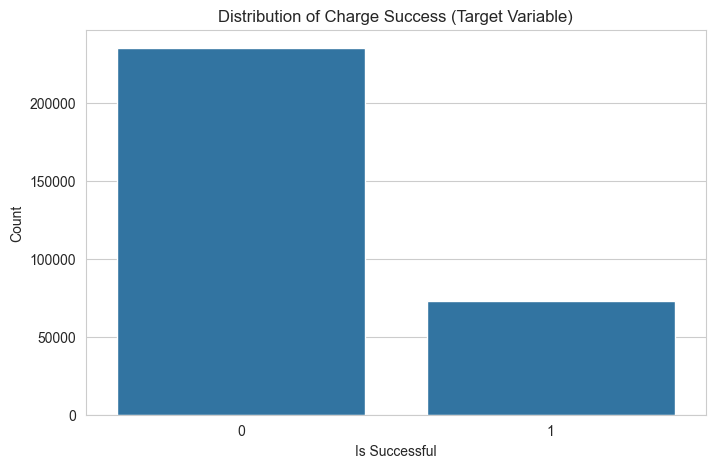

is_successful
0    76.402334
1    23.597666
Name: proportion, dtype: float64

In [17]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of the target variable 'is_successful'
plt.figure(figsize=(8, 5))
sns.countplot(x='is_successful', data=data_cleaned)
plt.title('Distribution of Charge Success (Target Variable)')
plt.xlabel('Is Successful')
plt.ylabel('Count')
plt.show()

# Calculating the percentage of successful vs unsuccessful charges
success_distribution = data_cleaned['is_successful'].value_counts(normalize=True) * 100
success_distribution

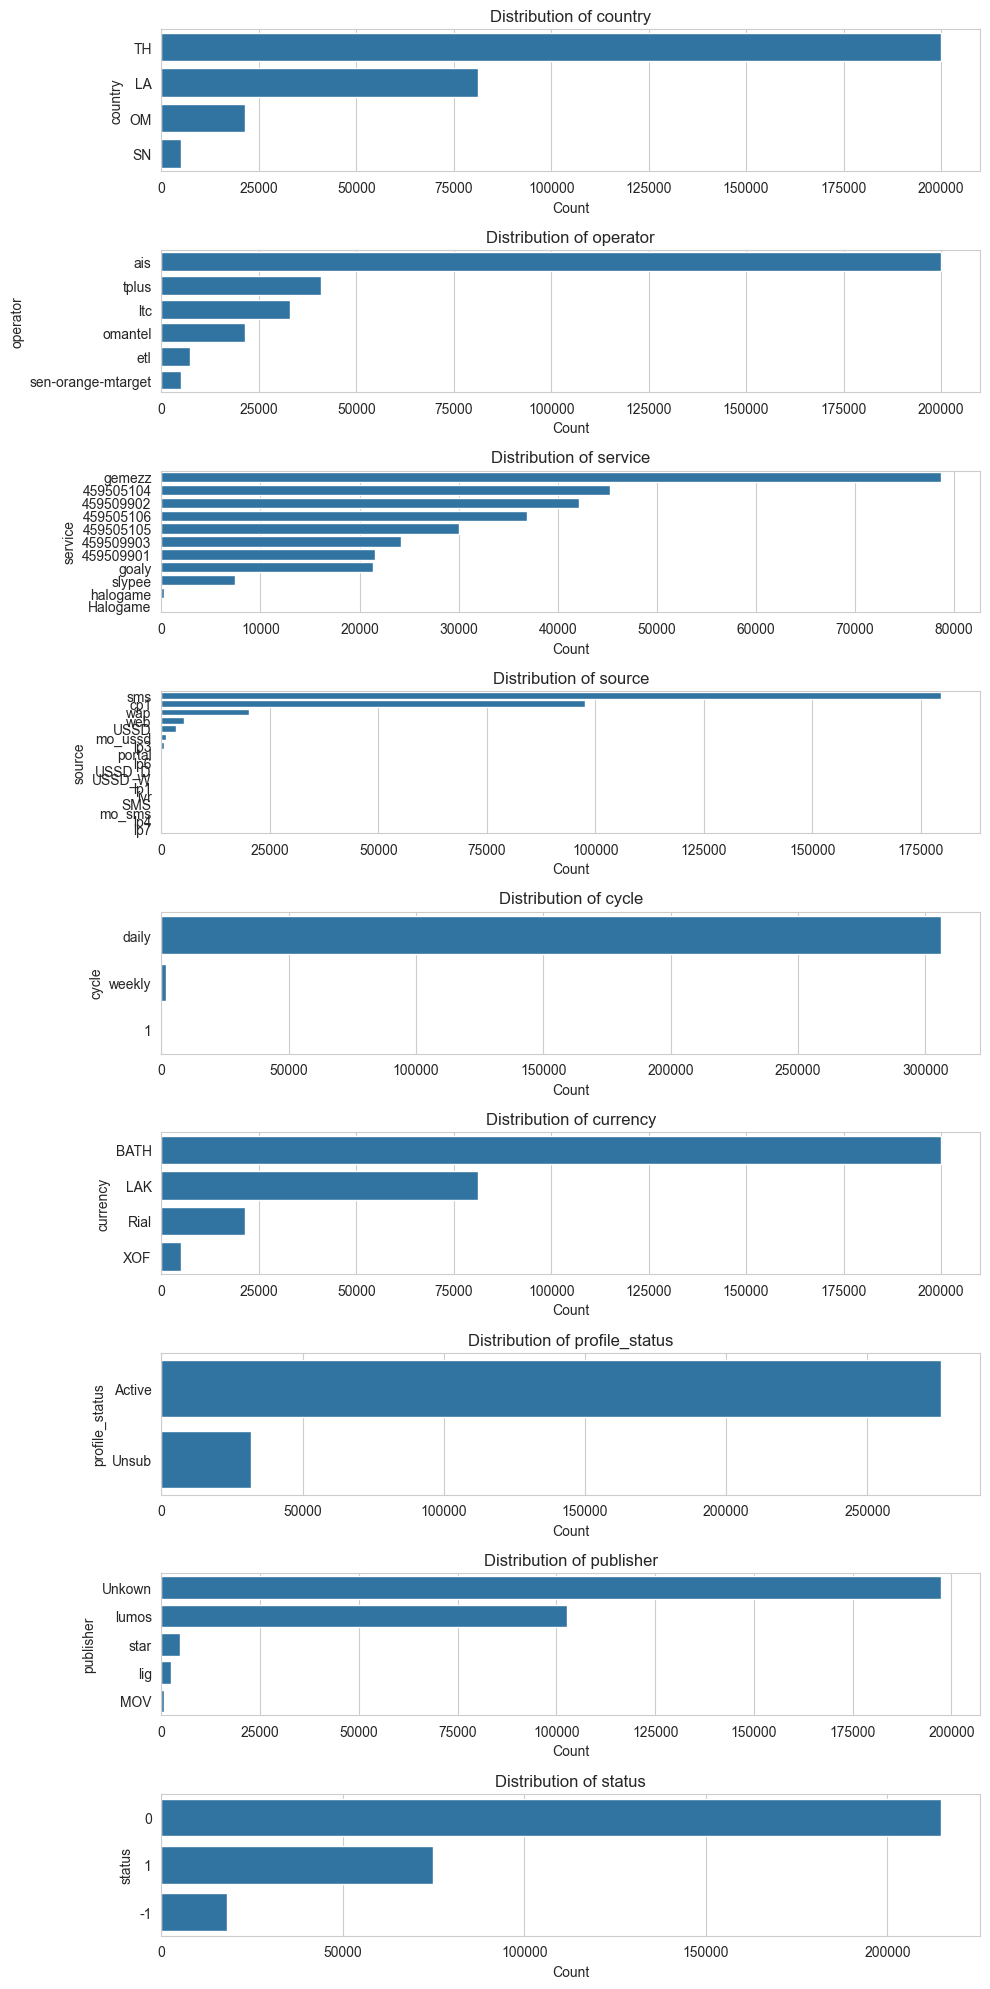

In [18]:
# Selecting a few key categorical variables for univariate analysis
categorical_vars = ['country', 'operator', 'service', 'source', 'cycle', 'currency', 'profile_status', 'publisher','status']

# Plotting distributions for these categorical variables
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(10, 20))

for i, var in enumerate(categorical_vars):
    sns.countplot(y=var, data=data_cleaned, ax=axes[i], order = data_cleaned[var].value_counts().index)
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

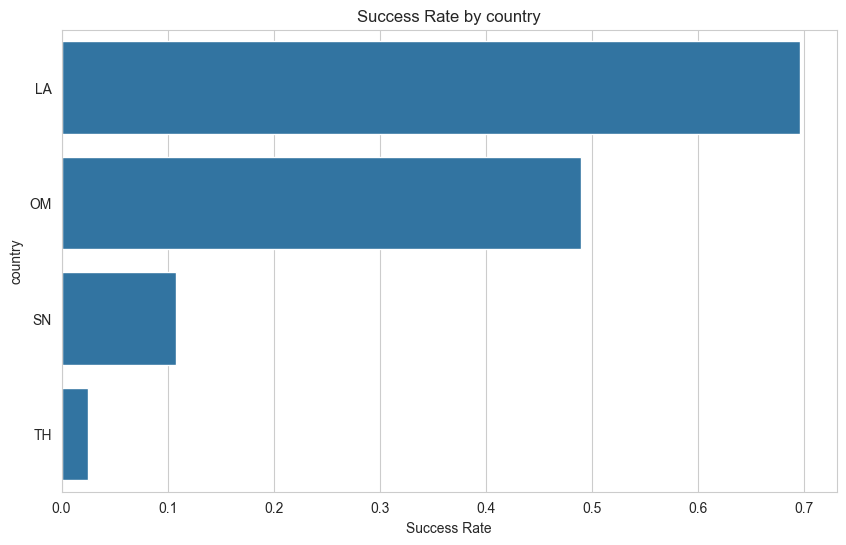

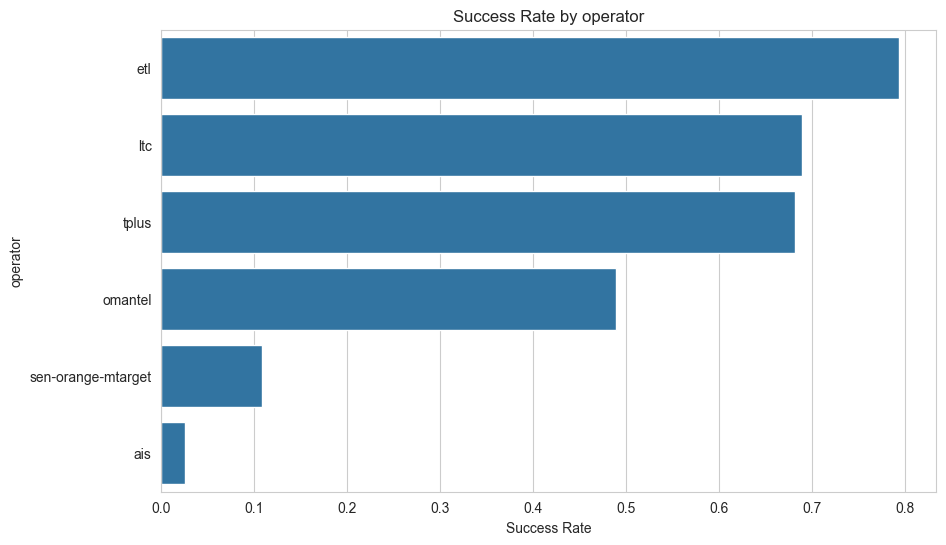

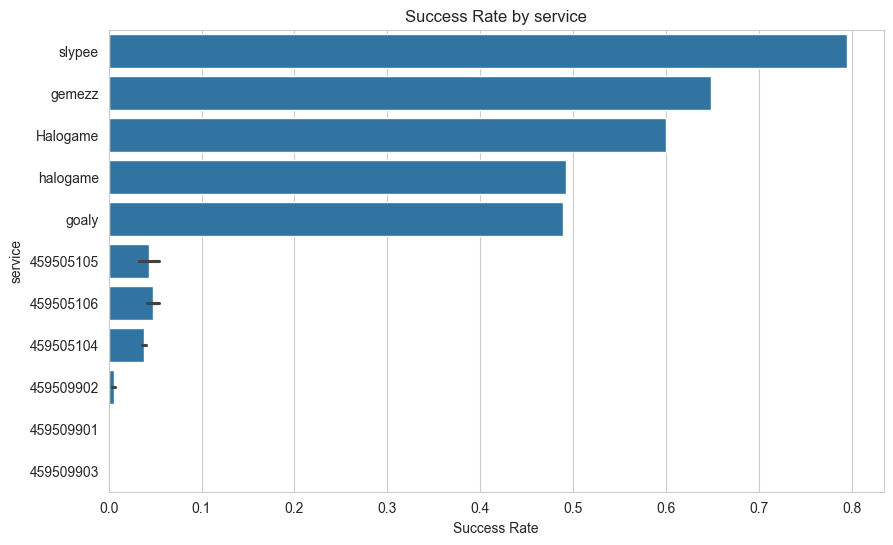

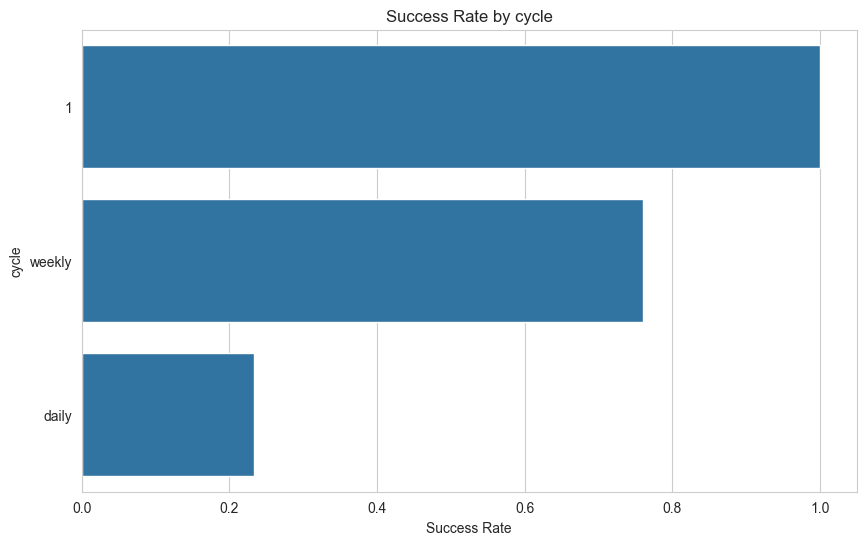

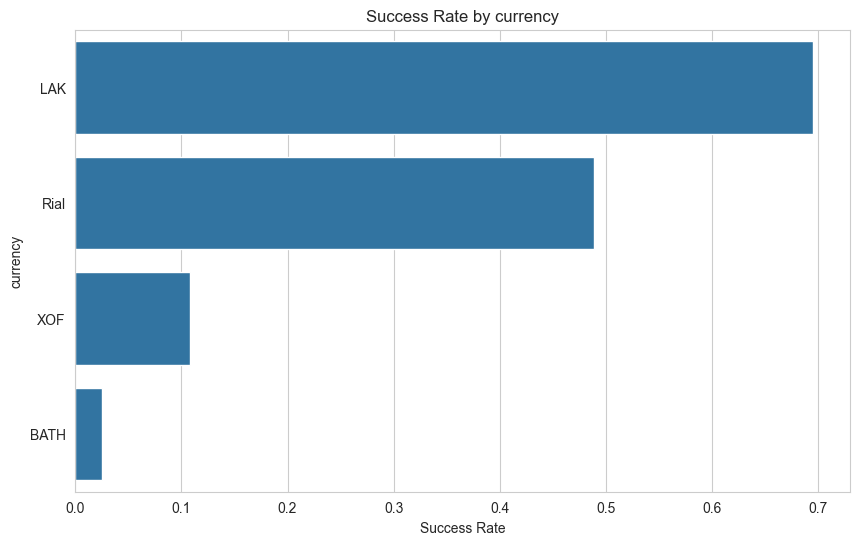

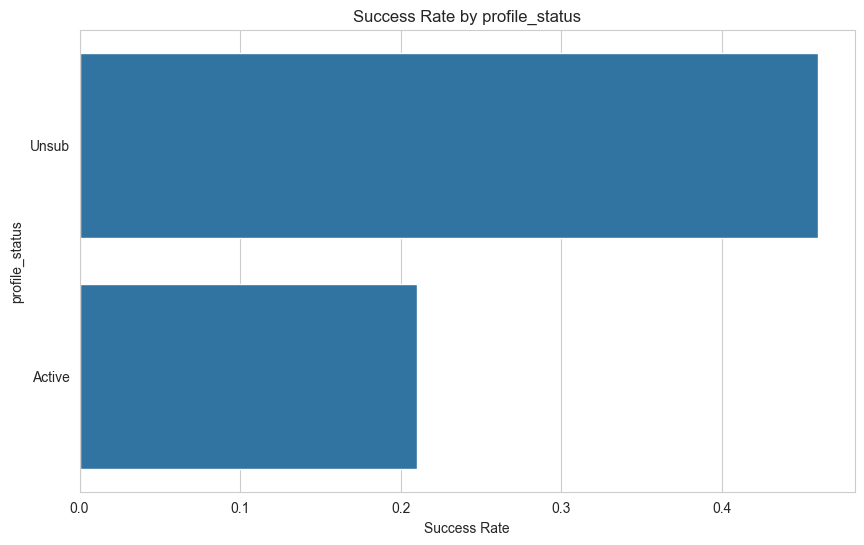

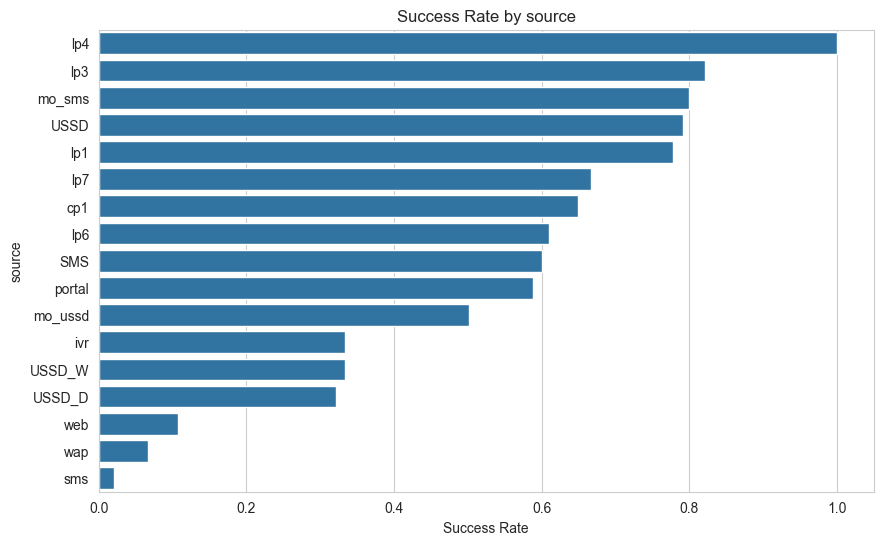

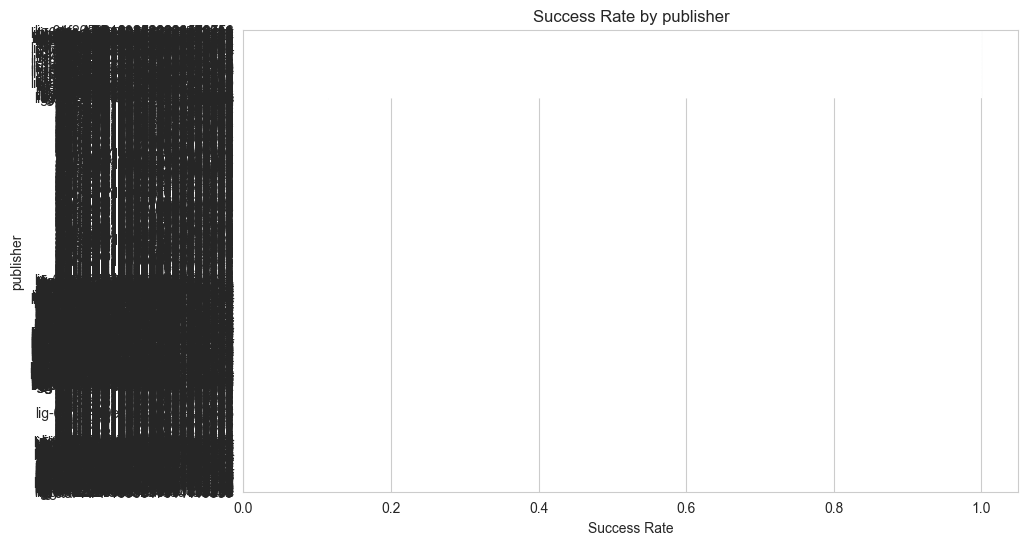

In [19]:

for var in ['country', 'operator', 'service', 'cycle', 'currency', 'profile_status', 'source', 'publisher']:
    # Calculate the success rate by category
    success_rate = data.groupby(var)['is_successful'].mean().sort_values(ascending=False)
    
    # Create a bar plot for visual comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x=success_rate, y=success_rate.index)
    plt.title(f'Success Rate by {var}')
    plt.xlabel('Success Rate')
    plt.ylabel(var)
    plt.show()

In [20]:
# Select features and target variable
X = data.drop('is_successful', axis=1)
y = data['is_successful']



In [35]:
print(X.columns)

Index(['country', 'operator', 'service', 'source', 'publisher'], dtype='object')


In [22]:
X = X.drop(columns=['Unnamed: 0', 'id','combined_created_date','profile_status'])
X = X.drop(columns=[ 'freemium_end_date', 'status','attempt_charging', 'unsubs_date','renewal_date','service_price_usd','cycle'])
X = X.drop(columns=['success_billing','currency','subs_date','adnet'])
X = X.drop(columns=['revenue', 'service_price', 'revenue_usd','unsubs_from'])

In [23]:
# Explicitly select categorical features
categorical_features = ['country', 'operator', 'service']

# Convert all categorical features to string type to ensure all data is uniform for OneHotEncoder
X[categorical_features] = X[categorical_features].astype(str)

# Preprocessing for categorical features: one-hot encode them
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical features: standard scaling
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        max_depth=20,  # Maximum depth of the trees
        max_leaf_nodes=500,  # Maximum number of leaf nodes
        min_samples_leaf=4,  # Minimum number of samples required to be at a leaf node
        min_samples_split=15,  # Minimum number of samples required to split an internal node
        n_estimators=100,  # Keeping the default number of trees if it was not tuned
        random_state=42
    ))
])
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     47149
           1       0.69      0.78      0.73     14420

    accuracy                           0.87     61569
   macro avg       0.81      0.84      0.82     61569
weighted avg       0.87      0.87      0.87     61569

[[42133  5016]
 [ 3191 11229]]


In [24]:
# Check the size of each set
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Confirm that the indices of the train and test set do not overlap
print("Overlap:", set(X_train.index) & set(X_test.index))

Training set size: (246275, 5)
Test set size: (61569, 5)
Overlap: set()


In [25]:
# Check for duplicates
#print("Duplicates:", X.duplicated().sum())

# Check if rows with identical features have the same target value
#X_check = X.copy()
#X_check['is_successful'] = y
#print("Inconsistent rows:", X_check.duplicated(subset=X.columns).sum() - X_check.duplicated().sum())

In [26]:
# Remove duplicate rows based on all columns except the target
#X_clean = X.drop_duplicates()
#y_clean = y[X_clean.index]


In [27]:
# Find the inconsistent rows
#inconsistent_mask = X_clean.duplicated(keep=False)
# You can then remove these rows or examine them further
#X_consistent = X_clean[~inconsistent_mask]
#y_consistent = y_clean[~inconsistent_mask]

In [28]:
# Check for duplicates after cleaning
#print("Remaining duplicates:", X_clean.duplicated().sum())

In [29]:
# Combine features and target for checking inconsistencies
#combined = X_clean.copy()
#combined['is_successful'] = y_clean

# Check for inconsistent rows
#print("Remaining inconsistent rows:", combined.duplicated(subset=X_clean.columns).sum() - combined.duplicated().sum())

In [30]:
# Split the cleaned data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [31]:
#model.fit(X_train, y_train)

In [32]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     47149
           1       0.69      0.78      0.73     14420

    accuracy                           0.87     61569
   macro avg       0.81      0.84      0.82     61569
weighted avg       0.87      0.87      0.87     61569

[[42133  5016]
 [ 3191 11229]]


In [33]:
# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation score for each fold
print("Cross-validation scores:", scores)

# Print average score across all folds
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.90868781 0.99793727 0.99978885 1.         0.34592646]
Average cross-validation score: 0.8504680794765396


In [34]:
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_clean, y_clean):
    print(y_clean.iloc[train_index].value_counts(normalize=True))

NameError: name 'X_clean' is not defined

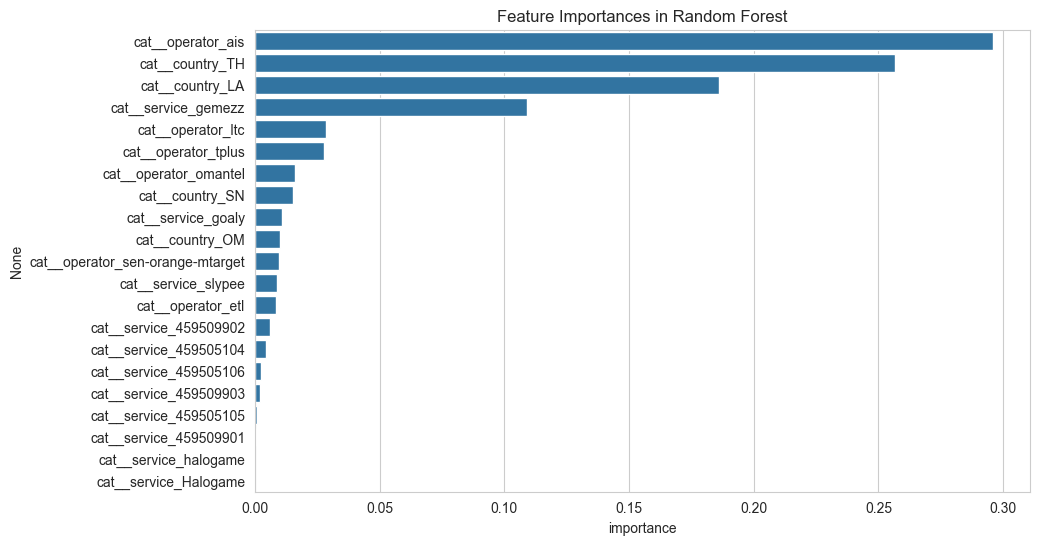

In [ ]:
# Access the preprocessor and the classifier from the pipeline
preprocessor = model.named_steps['preprocessor']
random_forest_model = model.named_steps['classifier']

# Transform the training data using the preprocessor to get the feature names
X_train_transformed = preprocessor.transform(X_train)
transformed_feature_names = preprocessor.get_feature_names_out()

# Now access the feature_importances_ attribute
feature_importances = pd.DataFrame(
    random_forest_model.feature_importances_,
    index=transformed_feature_names,
    columns=['importance']
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importances in Random Forest')
plt.show()

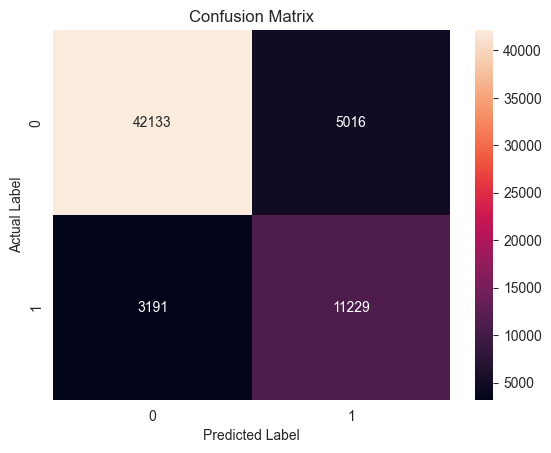

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Transform the features using the pipeline's preprocessor
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)

# Create a sample of the transformed training data if the dataset is large
X_sample = shap.sample(X_train_transformed, 100)  # Adjust the sample size as needed

In [ ]:
# Assuming 'model' is your trained Pipeline with a RandomForestClassifier named 'classifier'
rf_model = model.named_steps['classifier']
explainer = shap.TreeExplainer(rf_model)

NameError: name 'X_sample' is not defined

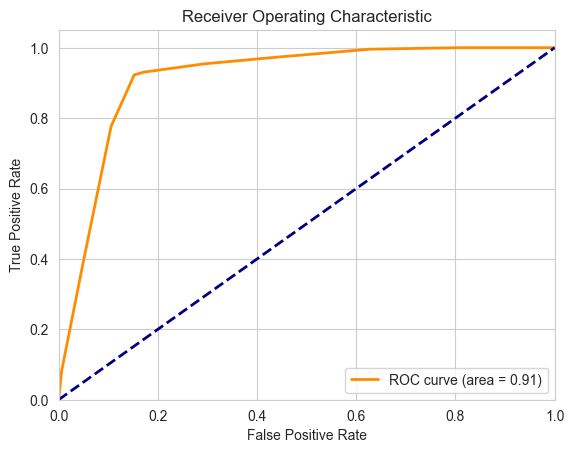

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Access the RandomForestClassifier within the pipeline
random_forest_model = model.named_steps['classifier']
preprocessor = model.named_steps['preprocessor']

# Get one individual tree from the forest. Use any index from 0 to n_estimators-1
tree = random_forest_model.estimators_[5]

# Get the feature names after preprocessing
feature_names_transformed = preprocessor.get_feature_names_out()

# Export as dot file
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=feature_names_transformed,
                           class_names=['Not Successful', 'Successful'],
                           filled=True, rounded=True,
                           special_characters=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree2")  # This will save the tree as a .png file

'decision_tree2.png'